This notebook simulates fluorescent melt curves predicted from NUPACK.

Yuxi, April 2022

# Load stuffs

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import json
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from RiboGraphViz import RGV
from RiboGraphViz import LoopExtruder, StackExtruder
from ipynb.draw import draw_struct
import nupack

from lmfit import Parameters, minimize

from nnn import util, fileio, processing, plotting, motif_fit, simulation
from nnn.arraydata import ErrorAdjust, ArrayData

import warnings
warnings.filterwarnings("ignore")

annotation = fileio.read_annotation('./data/annotation/nnnlib2b_annotation_20220418.tsv')
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:3,:],
                      annotation_file='./data/annotation/NNNlib2b_annotation_20220418.tsv')
revdata = ArrayData(replicate_df=replicate_df.iloc[3,:],
                   annotation_file='./data/annotation/NNNlib2b_annotation_20220418.tsv')
saltdata = ArrayData(replicate_df=replicate_df.iloc[4,:],
                    annotation_file='./data/annotation/NNNlib2b_annotation_20220418.tsv')

arr = arraydata.data.join(arraydata.annotation)
# for param in ['dG_37', 'dG_37_lb', 'dG_37_ub']:
#     arr[f'd{param}'] = util.get_ddX(arr, param, 'ConstructType')
# arr['ddG_37_NUPACK_salt_corrected'] = util.get_ddX(arr, 'dG_37_NUPACK_salt_corrected', 'ConstructType')
arr['scaffold'] =arr.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

salt = saltdata.data.join(saltdata.annotation)
# for param in ['dG_37', 'dG_37_lb', 'dG_37_ub']:
#     salt[f'd{param}'] = util.get_ddX(salt, param, 'ConstructType')
# salt['ddG_37_NUPACK_salt_corrected'] = util.get_ddX(salt, 'dG_37_NUPACK_salt_corrected', 'ConstructType')
# salt['ddG_37_NUPACK_150mM'] = util.get_ddX(salt, 'dG_37_NUPACK_150mM', 'ConstructType')
salt['scaffold'] = salt.apply(lambda row: f'{row.bottomScaffold}_{row.topScaffold}', axis=1)

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
80.98% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
81.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
31.22% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


In [2]:
r2 = arraydata.get_replicate_data('r2')
r2 = r2.join(annotation)

Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216.CPvariant.gz
86.41% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


# Distance in nt

## Schematic plots

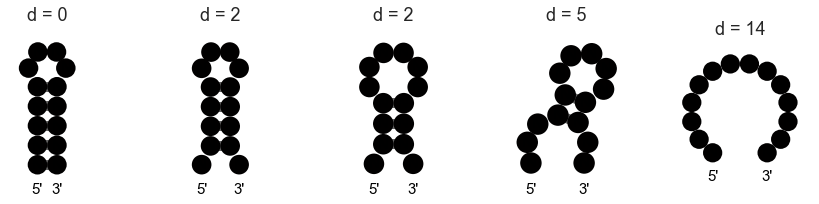

In [ ]:
seq = 'N'*14
struct = ['(((((....)))))', '.((((....)))).',
          '.(((......))).', '...((.....))..', '..............']
color = 'k'*14

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i,s in enumerate(struct):
    draw_struct(seq, s, color, ax=ax[i])
    d = util.get_fluor_distance_from_structure(s)
    ax[i].set_title('d = %d'%d, fontsize=18)
    
util.save_fig('./fig/simulate_curve/schematic.pdf')

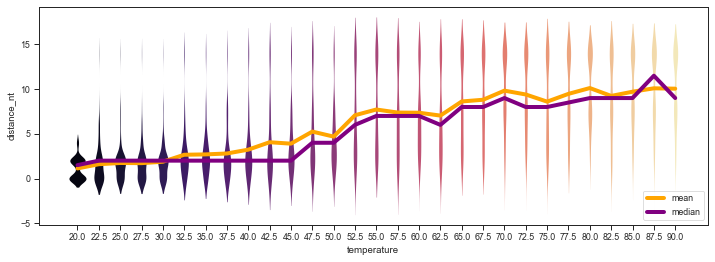

In [9]:
seq = 'AAATAGAAATATTT'
T = np.arange(20, 92.5, 2.5)
simulation.plot_nupack_curve_distance(seq, num_sample=100, sodium=0.15, T=T)
util.save_fig('./fig/simulate_curve/example_distance_nt_dist.pdf')


## Fit distance to fluorescence
Let's find the function from nt distance to fluorescence.

In [24]:
repeat_series = r2.query('ConstructType == "RepeatControls"')
repeat_series['length'] = repeat_series.RefSeq.apply(len)
dangle_5p = annotation.query('ConstructType=="strong_stem_var_5prime_dangleAlen"')

In [25]:
conds = [c for c in repeat_series.columns if c.endswith('_norm')]

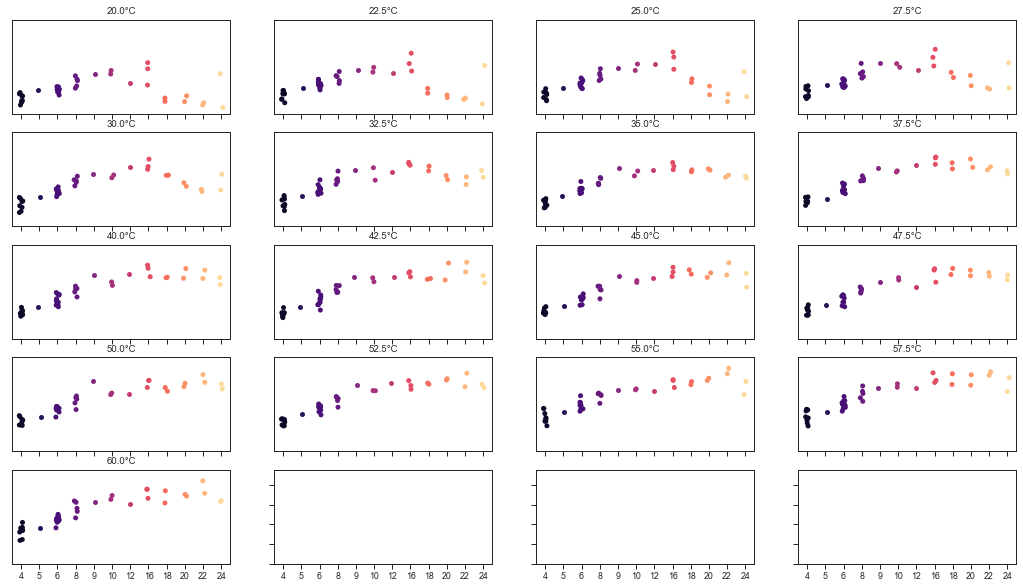

In [26]:
fig, ax = plt.subplots(5,4,figsize=(18,10), sharex=True, sharey=True)
ax = ax.flatten()
for i, cond in enumerate(conds):
    sns.stripplot(data=repeat_series, x='length', y=cond, palette='magma', ax=ax[i])
    ax[i].set_title(cond.split('_')[1] + '°C')
    ax[i].set_ylim([0, 1.2])
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlabel('')

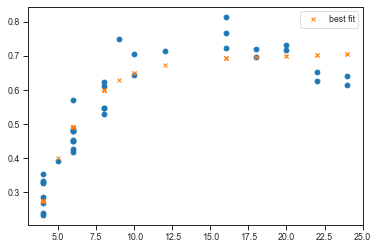

name,value,standard error,relative error,initial value,min,max,vary
a,86.3884420,8.19851417,(9.49%),50,-inf,inf,True
b,0.00000000,0.00000000,,0,0.00000000,inf,False
fmax,0.70859065,0.01487056,(2.10%),0.9,-inf,inf,True
fmin,-0.05000000,0.00000000,(0.00%),-0.05,-inf,inf,False


In [27]:
from lmfit import minimize, Parameters

def residual(params, x, data):
    a = params['a']
    b = params['b']
    fmax = params['fmax']
    fmin = params['fmin']
    
    model = (fmax - fmin) / (1 + (a * (x + b)**(-3))) + fmin
    
    return model - data

fmax, fmin = 0.9, -0.05
params = Parameters()
params.add('a', value=50)
params.add('b', value=0, min=0, vary=False)
params.add('fmax', value=fmax, vary=True)
params.add('fmin', value=fmin, vary=False)

x = np.array(repeat_series['length'], dtype=float)
data = repeat_series[conds[6]]
out = minimize(residual, params, args=(x, data))

plt.plot(x, data, 'o')
plt.plot(x, residual(out.params, x, data) + data, 'x', label='best fit')
plt.legend()
plt.show()
out.params

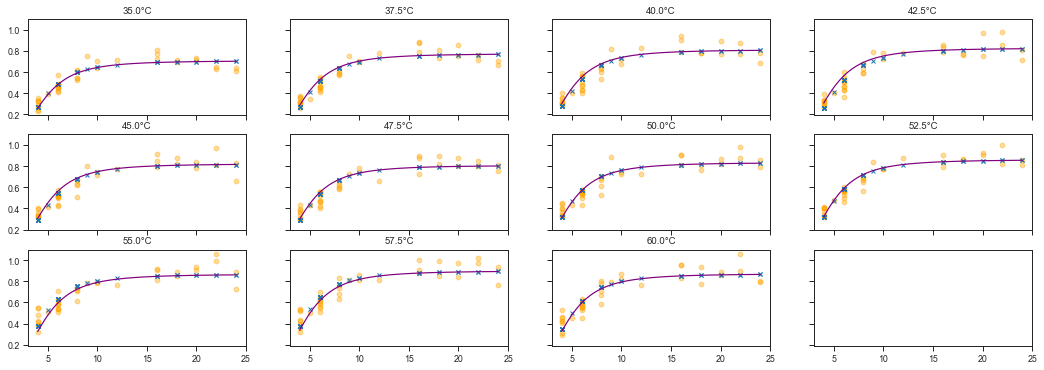

In [29]:
def residual(params, x, data):
    a = params['a']
    b = params['b']
    fmax = params['fmax']
    fmin = params['fmin']
    
    model = (fmax - fmin) / (1 + (a * (x + b)**(-3))) + fmin
    
    return model - data

fmax, fmin = 0.9, -0.05
params = Parameters()
params.add('a', value=50)
params.add('b', value=0, min=0, vary=False)
params.add('fmax', value=fmax, vary=True)
params.add('fmin', value=fmin, vary=False)


fig, ax = plt.subplots(3,4,figsize=(18,6), sharex=True, sharey=True)
ax = ax.flatten()
fitted_a = np.zeros_like(conds[6:])
fitted_fmax = np.zeros_like(conds[6:])
fitted_b = np.zeros_like(conds[6:])

x = np.array(repeat_series['length'], dtype=float)
for i, cond in enumerate(conds[6:]):   
    data = repeat_series[cond]
    out = minimize(residual, params, args=(x, data))

    ax[i].plot(x, data, 'o', c='orange', alpha=.4)
    ax[i].plot(x, residual(out.params, x, data) + data, 'x', label='best fit')
    
    xx = np.linspace(4,24,100)
    a = 93
    y = (float(out.params['fmax'].value) - fmin) / (1 + (a * (xx)**(-3))) + fmin
    ax[i].plot(xx, y, 'purple')
    ax[i].set_title(cond.split('_')[1] + '°C')
    
    # ax[i].set_xlabel('Distance (nt)')
    # ax[i].set_ylabel('Normalized fluorescence')

    fitted_a[i] = float(out.params['a'].value)
    fitted_fmax[i] = float(out.params['fmax'].value)
    fitted_b[i] = float(out.params['b'].value)
    
util.save_fig('./fig/signal_length/fitted_norm_fluor_vs_distance.pdf')
    

In [30]:
fitted_a = fitted_a.astype(float)
fitted_b = fitted_b.astype(float)
fitted_fmax = fitted_fmax.astype(float)

(50.0, 115.77811254071436)

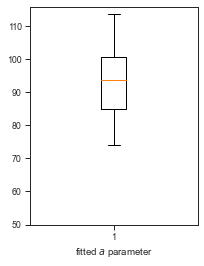

In [32]:

_,_ = plt.subplots(figsize=(3,4))
plt.boxplot(fitted_a)
plt.xlabel('fitted $a$ parameter')
plt.ylim(bottom=50)

Text(0.5, 0, 'fitted $f_{max}$ parameter')

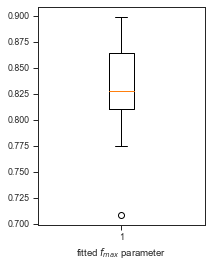

In [164]:

_,_ = plt.subplots(figsize=(3,4))
plt.boxplot(fitted_fmax)
plt.xlabel('fitted $f_{max}$ parameter')

In [33]:
np.mean(fitted_a), np.median(fitted_a)

(92.72627950264234, 93.83887254796186)

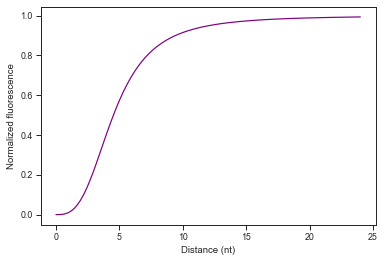

In [177]:
x = np.linspace(0,24,100)
a = 93
y = 1 / (1 + (a * x**(-3)))
plt.plot(x, y, 'purple')
plt.xlabel('Distance (nt)')
plt.ylabel('Normalized fluorescence')

util.save_fig('./fig/signal_length/fitted_norm_fluor_vs_distance_theoretical.pdf')


## Apply transform to the simulated distance distribution

In [278]:
arr = arraydata.data

Text(0, 0.5, 'norm fluorescence')

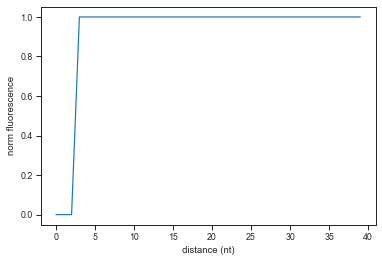

In [347]:
nt_range = np.arange(40)
# fluor_curve = simulation.distance_2_norm_fluor(nt_range, a=93)
# fluor_curve = (1 - np.exp(-0.05*nt_range)) * 1.5 + .4
fluor_curve = np.zeros_like(nt_range)
fluor_curve[3:] = 1

plt.plot(nt_range, fluor_curve)
plt.xlabel('distance (nt)')
plt.ylabel('norm fluorescence')

(-0.1, 1.2)

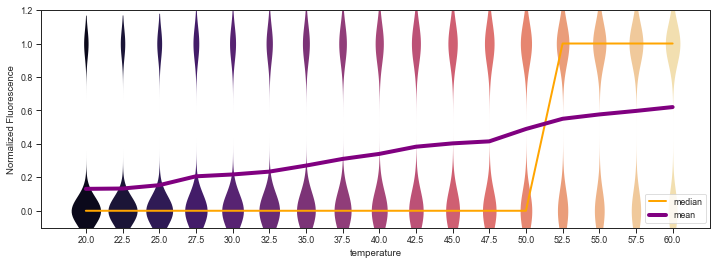

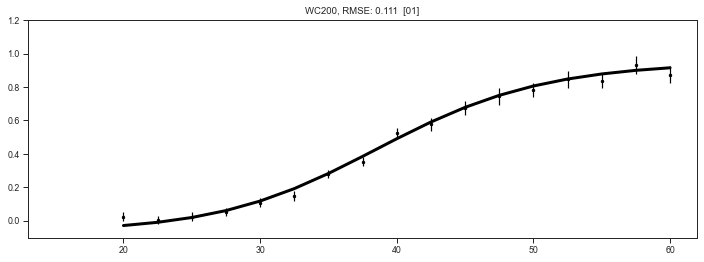

In [350]:

# row = r2.iloc[4,:]
row = r2.loc['WC200',:]
seq = row.RefSeq
# simulation.plot_nupack_curve(seq, num_sample=1000, sodium=.05, T=np.arange(20, 62.5, 2.5),
#                                       transform_curve=None)
simulation.plot_nupack_curve(seq, num_sample=1000, sodium=.075, T=np.arange(20, 62.5, 2.5),
                                      transform_curve=fluor_curve)
plt.ylim([-.1, 1.2])
fig, ax = plt.subplots(figsize=(12,4))
plotting.plot_actual_and_expected_fit(row, ax)
ax.set_ylim([-.1, 1.2])

In [327]:
import nupack
my_model = nupack.Model(material='DNA', celsius=120, sodium=.075, magnesium=0.0)
sampled_structures = nupack.sample(strands=[seq], num_sample=10, model=my_model)

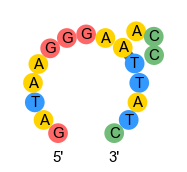

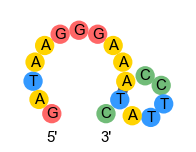

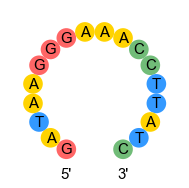

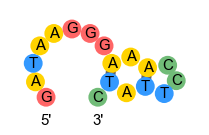

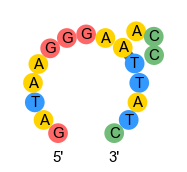

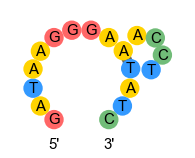

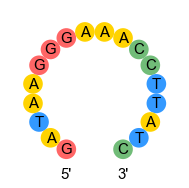

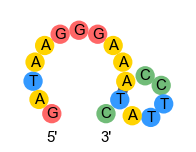

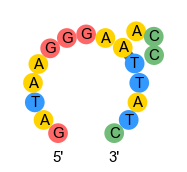

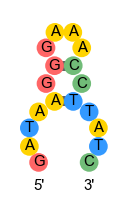

In [328]:
for s in sampled_structures:
    draw_struct(seq, str(s))

# Fit the simulated curve

In [12]:
curves = pd.read_pickle('./data/series_simulated/nupack_75mM.CPseries.pkl')

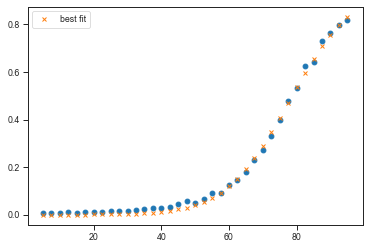

In [49]:
def residual(params, x, data):
    dH = params['dH']
    Tm = params['Tm']
    fmax = params['fmax']
    fmin = params['fmin']
    kB = 0.0019872
    
    model = fmin + (fmax - fmin) / (1 + np.exp((dH/kB) * (1/(Tm + 273.15) - 1/(x + 273.15))))

    return model - data

T = curves.columns
y = curves.iloc[400, :]
# fmax, fmin = 0.9, -0.05
params = Parameters()
params.add('dH', value=-40, max=0.0, min=-200.0)
params.add('Tm', value=50, max=300, min= -100)
params.add('fmax', value=1, vary=False)
params.add('fmin', value=0.0, vary=False)

out = minimize(residual, params, args=(T, y))

plt.plot(T, y, 'o')
plt.plot(T, residual(out.params, T, y) + y, 'x', label='best fit')
plt.legend()
plt.show()
out

In [53]:
def residual(params, x, data):
    dH = params['dH']
    Tm = params['Tm']
    kB = 0.0019872
    
    model = 1 / (1 + np.exp((dH/kB) * (1/(Tm + 273.15) - 1/(T + 273.15))))

    return model - data

def fit_curve(y, T, plot=False, ylim=False):
    params = Parameters()
    params.add('dH', value=-40, max=0.0, min=-200.0)
    params.add('Tm', value=50, max=300, min= -100)
    out = minimize(residual, params, args=(T, y))
    
    dH = out.params['dH'].value
    Tm = out.params['Tm'].value
    dG_37 = util.get_dG(dH, Tm, 37.0)
    rmse = np.sqrt(np.mean((y - out.residual)**2))
    chisq = out.chisqr
    
    
    if plot:
        plt.plot(T, y, 'o')
        plt.plot(T, residual(out.params, T, y) + y, 'x', label='best fit')
        if ylim:
            plt.ylim([-.05, 1.05])
        plt.legend()
        plt.show()
    
    return np.array([dH, Tm, dG_37, rmse, chisq], dtype=float)

TETNN487


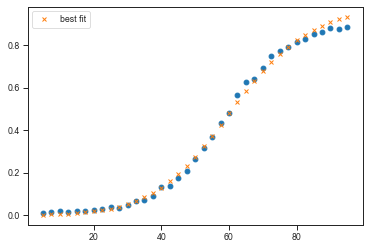

array([-1.88577942e+01,  6.09487350e+01, -1.35175704e+00,  4.99652897e-01,
        1.32249051e-02])

In [206]:
T = curves.columns
y = curves.iloc[999, :]
print(y.name)
fit_curve(y, T, plot=True, ylim=False)

## Exploring the fitted simulation parameters

Fitted on all of the variants and plotting some results.
75 mM sodium

In [5]:
sim_param = pd.read_pickle('./data/series_simulated/nupack_75mM.CPvariant.pkl')

In [6]:
sim_param = pd.read_pickle('./data/series_simulated/nupack_75mM.CPvariant.pkl')
sim_param.rename(columns={s:s+'_simulated' for s in sim_param.columns}, inplace=True)
lib = r2.join(sim_param)

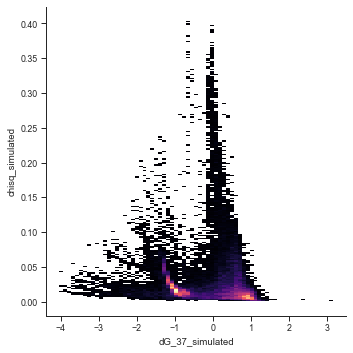

In [7]:
df = lib.query('chisq_simulated < 0.1 & Tm_simulated > 0 & Tm_simulated < 200')
sns.displot(x=lib.dG_37_simulated, y=lib.chisq_simulated, cmap='magma')

#### Some correlation plots

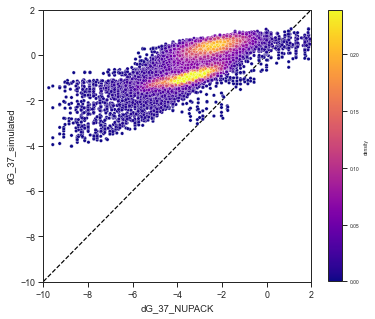

In [10]:
plotting.plot_colored_scatter_comparison(data=df, x='dG_37_NUPACK', y='dG_37_simulated', lim=[-10,2])

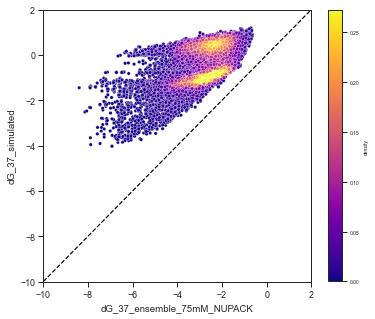

In [11]:
plotting.plot_colored_scatter_comparison(data=df, x='dG_37_ensemble_75mM_NUPACK', y='dG_37_simulated', lim=[-10,2])

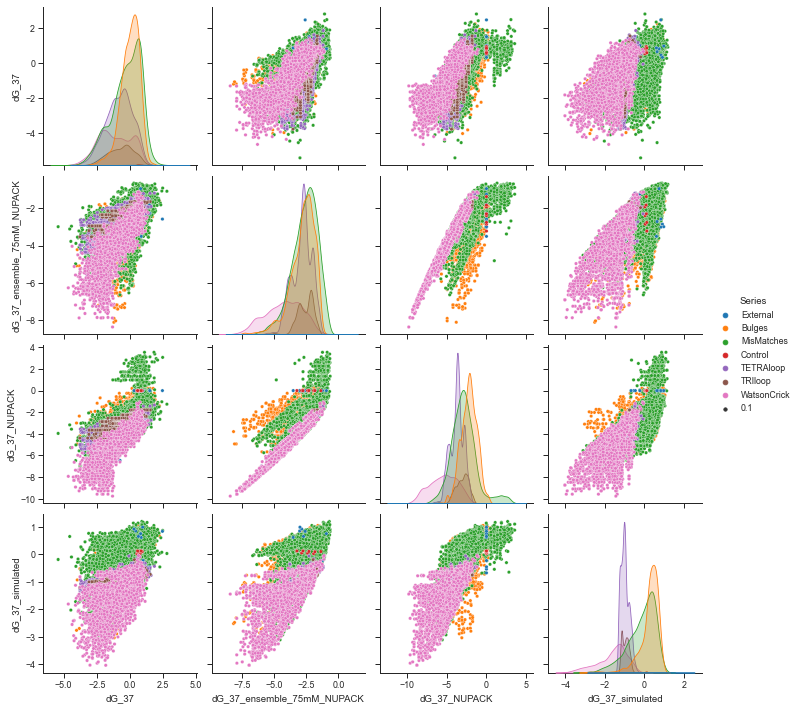

In [187]:
df = lib.query('chisq_simulated < 0.1 & Tm_simulated > 0 & Tm_simulated < 200')#.query('Series == "WatsonCrick"')
sns.pairplot(data=df, vars=['dG_37', 'dG_37_ensemble_75mM_NUPACK', 'dG_37_NUPACK', 'dG_37_simulated'], hue='Series', plot_kws=dict(alpha=1, size=0.1))

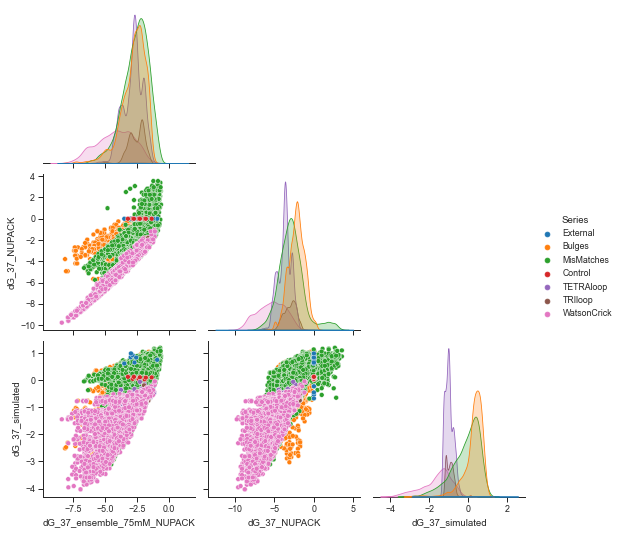

In [190]:
df = lib.query('chisq_simulated < 0.1 & Tm_simulated > 0 & Tm_simulated < 200')#.query('Series == "WatsonCrick"')
sns.pairplot(data=df, vars=['dG_37_ensemble_75mM_NUPACK', 'dG_37_NUPACK', 'dG_37_simulated'], hue='Series', corner=True)

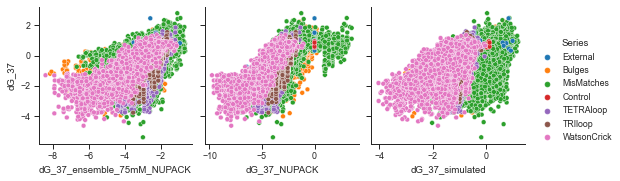

In [198]:
df = lib.query('chisq_simulated < 0.1 & Tm_simulated > 0 & Tm_simulated < 200')#.query('Series == "WatsonCrick"')
pg = sns.pairplot(data=df, y_vars=['dG_37'], x_vars=['dG_37_ensemble_75mM_NUPACK', 'dG_37_NUPACK', 'dG_37_simulated'], hue='Series')

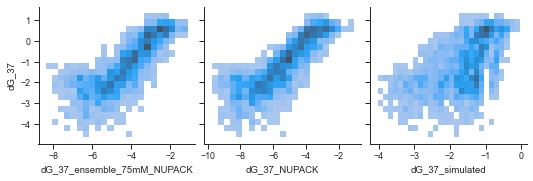

In [200]:
df = lib.query('chisq_simulated < 0.1 & Tm_simulated > 0 & Tm_simulated < 200').query('Series == "WatsonCrick"')
pg = sns.pairplot(data=df, y_vars=['dG_37'], x_vars=['dG_37_ensemble_75mM_NUPACK', 'dG_37_NUPACK', 'dG_37_simulated'], kind='hist')

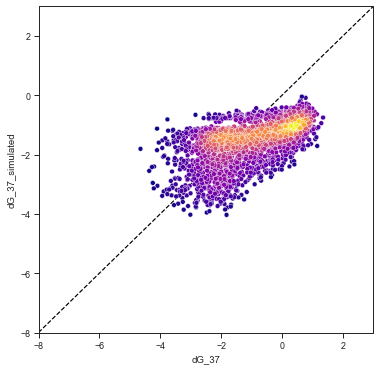

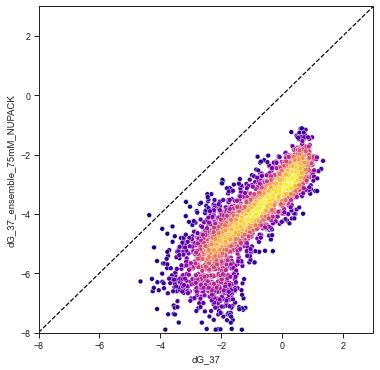

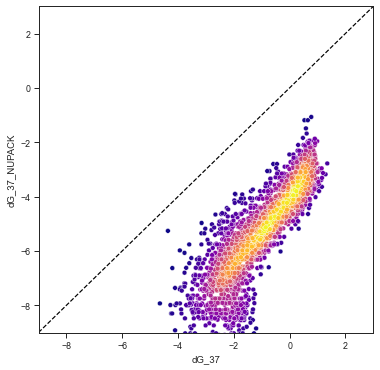

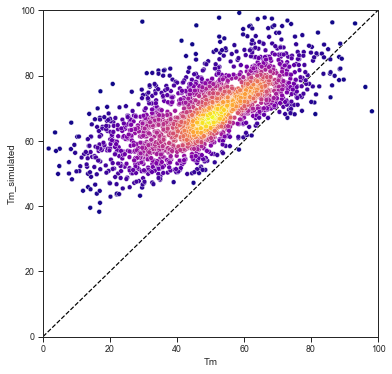

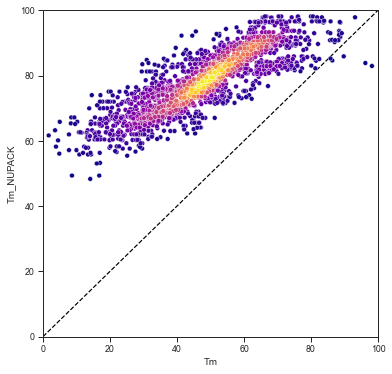

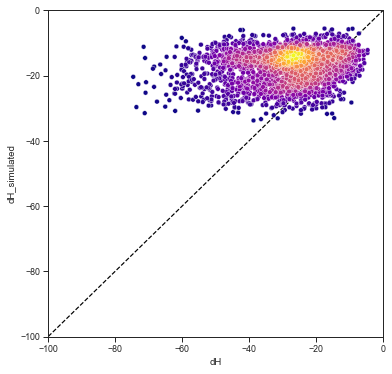

In [178]:
df = lib.query('chisq_simulated < 0.1 & Tm_simulated > 0 & Tm_simulated < 200').query('Series == "WatsonCrick"')
plotting.plot_colored_scatter_comparison(data=df, x='dG_37', y='dG_37_simulated', lim=[-8,3])
plotting.plot_colored_scatter_comparison(data=df, x='dG_37', y='dG_37_ensemble_75mM_NUPACK', lim=[-8,3])
plotting.plot_colored_scatter_comparison(data=df, x='dG_37', y='dG_37_NUPACK', lim=[-9,3])
plotting.plot_colored_scatter_comparison(data=df, x='Tm', y='Tm_simulated', lim=[0,100])
plotting.plot_colored_scatter_comparison(data=df, x='Tm', y='Tm_NUPACK', lim=[0,100])
plotting.plot_colored_scatter_comparison(data=df, x='dH', y='dH_simulated', lim=[-100,0])

In [8]:
lib['ddG_sim_ensemble'] = lib.dG_37_simulated - lib.dG_37_ensemble_75mM_NUPACK

deviate_variants = lib.sort_values(by='ddG_sim_ensemble', ascending=False).iloc[:100,:].index.tolist()

(40.0, 101.0)

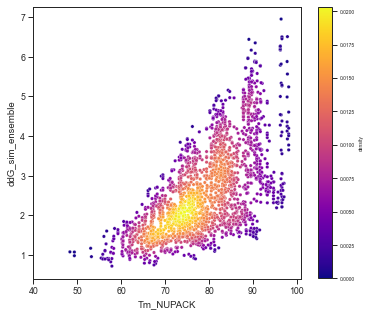

In [24]:
plotting.plot_colored_scatter_comparison(data=lib.query('Series == "WatsonCrick"'), y='ddG_sim_ensemble', x='Tm_NUPACK')
plt.xlim([40, 101])
# plt.yscale('log')

#### Directly looking at some curves

In [10]:
sim_param = pd.read_pickle('./data/series_simulated/nupack_75mM.CPvariant.pkl')
sim_param.rename(columns={s:s+'_NUPACK' for s in sim_param.columns}, inplace=True)

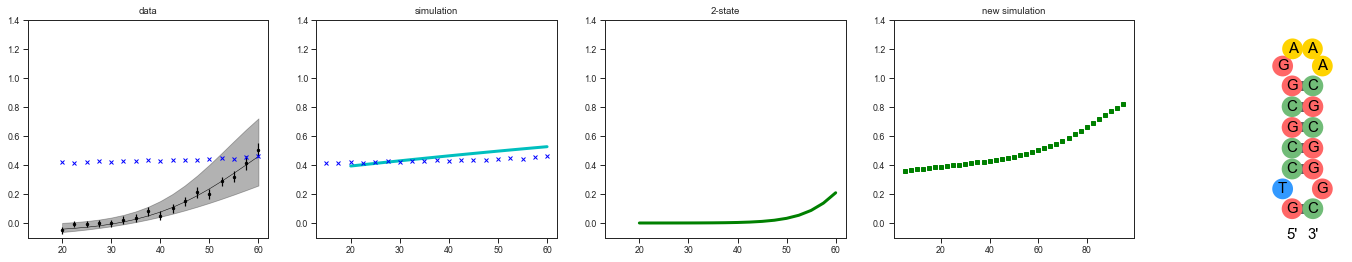

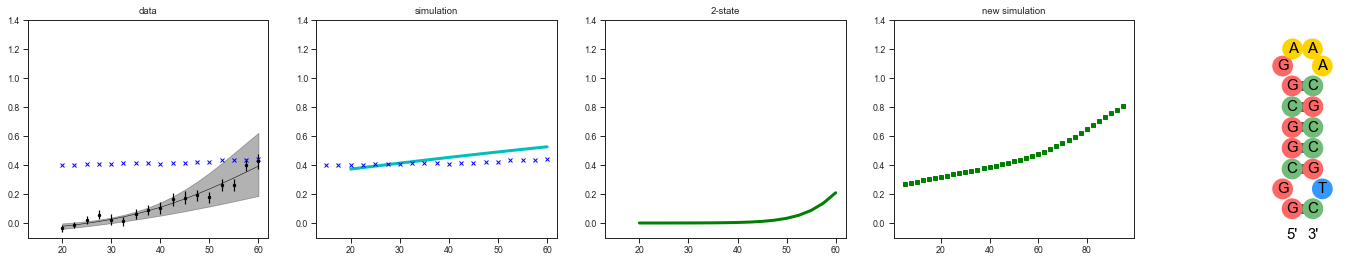

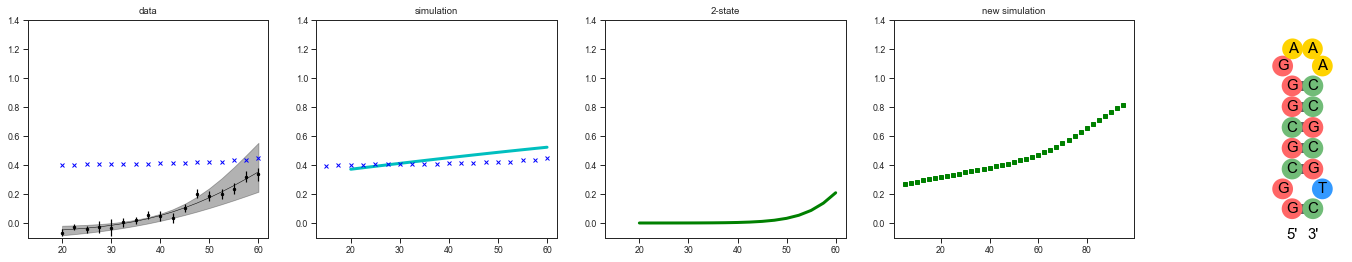

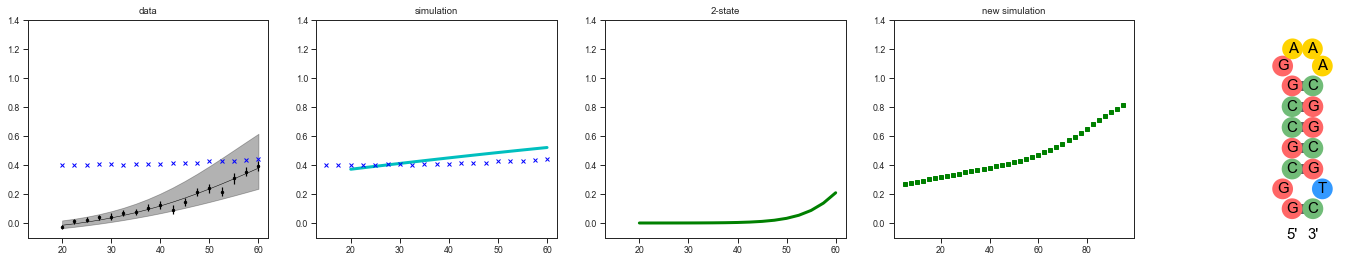

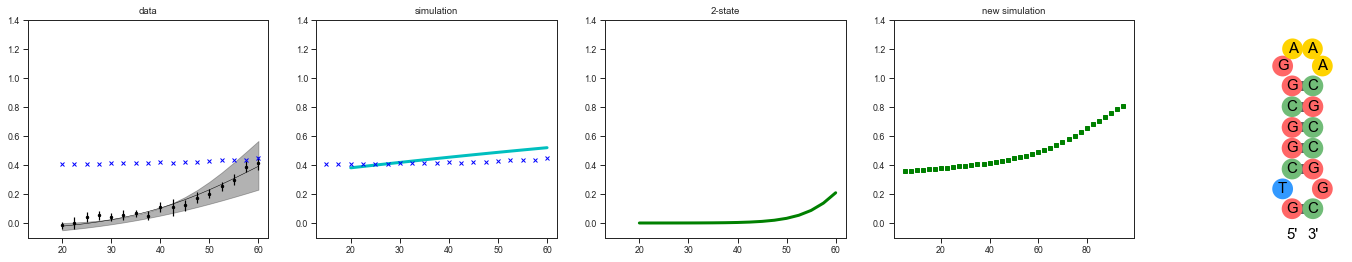

In [13]:
from nnn.simulation import *
# seq = 'WC1001'#r2.sample().index[0]
T = np.arange(20, 62.5, 2.5)
T_more = np.arange(5, 97.5, 2.5)
distance_curve = get_transform_curve(max_len=50, a=93)

for seqid in deviate_variants[15:20]:
    seq = annotation.loc[seqid, 'RefSeq']
    fig, ax = plt.subplots(1, 5, figsize=(25,4))
    plotting.plot_actual_and_expected_fit(r2.loc[seqid,:], ax=ax[0])
    plotting.plot_NUPACK_curve(sim_param.loc[seqid,:], ax=ax[1], c='c')
    ax[0].plot(T, curves.loc[seqid, T], 'bx')
    ax[1].plot(T_more, curves.loc[seqid, T_more], 'bx')
    plotting.plot_corrected_NUPACK_curve(annotation.loc[seqid,:], ax=ax[2], sodium=.075, c='g')
    y = simulate_nupack_curve(seq, sodium=0.075, T=T_more, distance_curve=distance_curve,
                          dG_gap_kcal_mol=100)
    ax[3].plot(T_more, y, 'gs')
    ax[3].set_ylim([-0.1, 1.4])
    draw_struct(seq, annotation.loc[seqid, 'TargetStruct'], ax=ax[4])
    ax[0].set_title('data')
    ax[1].set_title('simulation')
    ax[2].set_title('2-state')
    ax[3].set_title('new simulation')
    

# Simulate distributions with subopt structures

### Testing nupack subopt structure function

In [45]:
row = annotation.sample().iloc[0,:]
seq = row.RefSeq
target_struct = row.TargetStruct

In [49]:
seq = 'TTACTGAAAAGTAA'
kB = 0.0019872
energy_gap = 1.5
celsius = 50
sodium = 1.0
my_model = my_model = nupack.Model(material='DNA', celsius=celsius, sodium=sodium, magnesium=0.0)
subopt_struct = nupack.subopt(strands=[seq], energy_gap=energy_gap, model=my_model)
pfunc, dG = nupack.pfunc(strands=[seq], model=my_model)
print(subopt_struct)

[StructureEnergy(Structure('(((((....)))))'), energy=-1.20721435546875, stack_energy=-1.20721435546875), StructureEnergy(Structure('..(((....)))..'), energy=-1.6257224082946777, stack_energy=-1.1152312755584717), StructureEnergy(Structure('.((((....)))).'), energy=-1.4904751777648926, stack_energy=-0.6963098645210266), StructureEnergy(Structure('..............'), energy=0.0, stack_energy=0.0), StructureEnergy(Structure('...((....))...'), energy=-0.46042394638061523, stack_energy=0.0)]


In [76]:
subopt_struct[-1].structure

Structure('.((((....)))).')

In [56]:
print('Prob: %.4f'% prob)
kB_T_inv = (kB * (50 + 273.15))**(-1)
print('Prob from energy: %.4f'% (np.exp(-kB_T_inv * subopt_struct[-1].energy) / float(pfunc)))
print('Prob from stack energy: %.4f'% (np.exp(-kB_T_inv * subopt_struct[-1].stack_energy) / float(pfunc)))
# print('Prob from energy + stack energy: %.4f'% (np.exp(-kB_T_inv * (subopt_struct[-1].stack_energy + subopt_struct[-1].energy)) / float(pfunc)))
print('Prob from energy / sum of energy: %.4f'% (np.exp(-subopt_struct[-1].energy) / np.exp(-np.sum([s.energy for s in subopt_struct]))))
print('Prob from stack energy / sum of stack energy: %.4f'% (np.exp(-subopt_struct[-1].stack_energy) / np.exp(-np.sum([s.stack_energy for s in subopt_struct]))))

Prob: 0.1904
Prob from energy: 0.1904
Prob from stack energy: 0.0782
Prob from energy / sum of energy: 0.0656
Prob from stack energy / sum of stack energy: 0.0656


In [52]:
row = annotation.loc['WC999',:]
seq = row.RefSeq
target_struct = row.TargetStruct
kB = 0.0019872
energy_gap = 1
celsius = 50
sodium = 1.0
my_model = nupack.Model(material='dna04', celsius=celsius, sodium=sodium, magnesium=0.0, ensemble='nostacking')
subopt_struct = nupack.subopt(strands=[seq], energy_gap=energy_gap, model=my_model)
pfunc, dG = nupack.pfunc(strands=[seq], model=my_model)
print(subopt_struct)
print(seq)

[StructureEnergy(Structure('(((((....)))))'), energy=-1.20721435546875, stack_energy=-1.20721435546875), StructureEnergy(Structure('.((((....)))).'), energy=-0.4964291453361511, stack_energy=-0.4964291453361511)]
TTACTGAAAAGTAA


In [55]:
my_model = nupack.Model(material='dna04', celsius=celsius, sodium=sodium, magnesium=0.0, ensemble='nostacking')
e1 = nupack.structure_energy(strands=['TTACTGAAAAGTAA'], structure='(((((....)))))', model=my_model)
e2 = nupack.structure_energy(strands=['TTACTGAAAAGTAA'], structure='.((((....)))).', model=my_model)
e3 = nupack.structure_energy(strands=['TTACTGAAAAGTAA'], structure='..(((....)))..', model=my_model)
print(e1, e2, e3)

-1.207214251168791 -0.4964291471868467 -0.19390778655489394


In [75]:
from nnn.simulation import *

Text(0.5, 1.0, 'simulation 2')

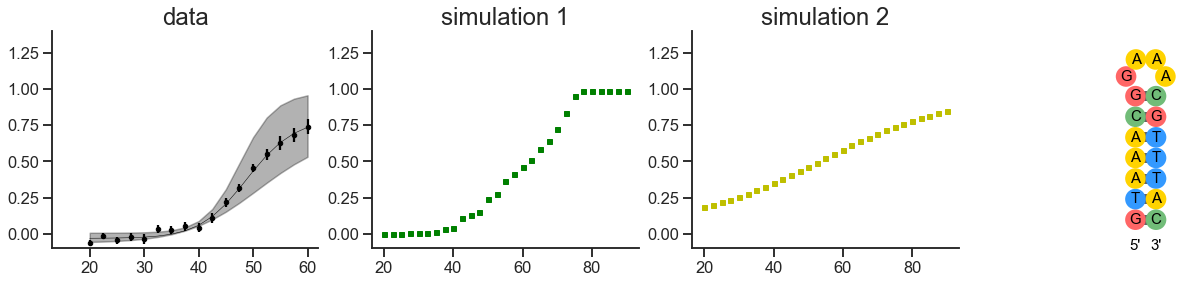

In [95]:
sns.set_context('talk')
seqid = 'WC779'#'WC556'#'WC778'#r2.sample().index[0]
seq = annotation.loc[seqid,'RefSeq']
T = np.arange(20, 62.5, 2.5)
T_more = np.arange(20, 92.5, 2.5)
distance_curve = get_transform_curve(max_len=50, a=93)
y = simulate_nupack_curve(seq, sodium=0.075, T=T_more, distance_curve=distance_curve,
                          dG_gap_kT=2)
curve = simulation.simulate_nupack_curve_all_struct(seq, T=T_more, sodium=0.075, dG_gap_kT=2)

ylim = [-0.1,1.4]
fig, ax = plt.subplots(1, 4, figsize=(22,4))
plotting.plot_actual_and_expected_fit(r2.loc[seqid,:], ax=ax[0])
# ax[1].plot(T_more, y, 'gs', markersize=5)
ax[1].plot(T_more, y, 'gs', markersize=5)
ax[2].plot(T_more, curve, 'ys', markersize=5)
# plot_nupack_curve_by_sampling(seq, num_sample=1000, sodium=0.075, T=T,
#                       transform_curve=distance_curve, ax=ax[2])
draw_struct(seq, annotation.loc[seqid, 'TargetStruct'], ax=ax[3])
sns.despine()
for a in ax[:3]:
    a.set_ylim(ylim)
ax[0].set_title('data', size=24)
ax[1].set_title('simulation 1', size=24)
ax[2].set_title('simulation 2', size=24)

T = 5.0 : 8
T = 7.5 : 12
T = 10.0 : 3
T = 12.5 : 4
T = 15.0 : 10
T = 17.5 : 3
T = 20.0 : 7
T = 22.5 : 1
T = 25.0 : 3
T = 27.5 : 4
T = 30.0 : 5
T = 32.5 : 4
T = 35.0 : 5
T = 37.5 : 3
T = 40.0 : 3
T = 42.5 : 2
T = 45.0 : 2
T = 47.5 : 3
T = 50.0 : 2
T = 52.5 : 2
T = 55.0 : 2
T = 57.5 : 3
T = 60.0 : 1
T = 62.5 : 0
T = 65.0 : 0
T = 67.5 : 0
T = 70.0 : 0
T = 72.5 : 0
T = 75.0 : 0
T = 77.5 : 0
T = 80.0 : 0
T = 82.5 : 0
T = 85.0 : 0
T = 87.5 : 0
T = 90.0 : 0
T = 92.5 : 0
T = 5.0 : 20
T = 7.5 : 19
T = 10.0 : 8
T = 12.5 : 12
T = 15.0 : 15
T = 17.5 : 9
T = 20.0 : 7
T = 22.5 : 4
T = 25.0 : 6
T = 27.5 : 7
T = 30.0 : 9
T = 32.5 : 6
T = 35.0 : 6
T = 37.5 : 4
T = 40.0 : 4
T = 42.5 : 3
T = 45.0 : 4
T = 47.5 : 5
T = 50.0 : 3
T = 52.5 : 3
T = 55.0 : 3
T = 57.5 : 1
T = 60.0 : 0
T = 62.5 : 0
T = 65.0 : 0
T = 67.5 : 0
T = 70.0 : 0
T = 72.5 : 0
T = 75.0 : 0
T = 77.5 : 0
T = 80.0 : 0
T = 82.5 : 0
T = 85.0 : 0
T = 87.5 : 0
T = 90.0 : 0
T = 92.5 : 0
T = 5.0 : 31
T = 7.5 : 29
T = 10.0 : 21
T = 12.5 : 21
T = 15.0

(-0.1, 1.1)

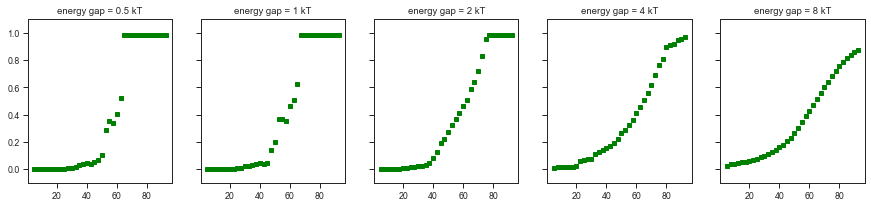

In [86]:
%%time
T = np.arange(5, 95, 2.5)
sodium = 0.075
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharey=True)
for i, energy_gap in enumerate([0.5, 1, 2, 4, 8]):
    # args = dict(seq=seq, distance_curve=distance_curve, sodium=0.075, T=T, dG_gap_kT=energy_)
    y_energy = simulate_nupack_curve(seq, sodium=sodium, T=T, dG_gap_kT=energy_gap, energy_key='energy')
    # y_stack_energy = simulate_nupack_curve(seq, sodium=sodium, T=T, dG_gap_kT=energy_gap, energy_key='stack_energy')
    ax[i].plot(T, y_energy, 'gs', label='energy')
    # ax[i].plot(T, y_stack_energy, 'gx', label='stack_energy')
    # ax[i].set_title('energy gap = %.1f kcal/mol'%energy_gap)
    ax[i].set_title('energy gap = %.1g kT'%energy_gap)
# plt.legend()
plt.ylim([-0.1, 1.1])

In [71]:
nt_range = np.arange(50)
distance_curve = distance_2_norm_fluor(nt_range, a=93)

structures = [str(s.structure) for s in subopt_struct]
energies = [s.energy for s in subopt_struct]
unfolded_stuct = '.'*len(seq)

if not unfolded_stuct in structures:
    structures.append(unfolded_stuct)
    energies.append(0.0)
    
distances = [util.get_fluor_distance_from_structure(s) for s in structures]
fluors = distance_curve[distances]

weights = np.exp(-np.array(energies))
np.sum(weights * fluors) / np.sum(weights)

In [37]:
df = annotation.query('Series == "WatsonCrick"').sample(10)
results = simulation.simulate_CPseries(df, sodium=0.075, T=np.arange(20, 62.5, 2.5), n_jobs=1, dG_gap_kT=1)

No parallelization


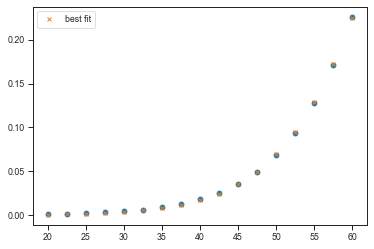

array([-2.90689225e+01,  6.96791819e+01, -2.77090941e+00,  8.51904725e-04,
        1.23376082e-05])

In [43]:
simulation.fit_curve(curves[9,:], T, plot=True)

In [ ]:
simulation.fit_simulated_nupack_series(results)

In [44]:
df

,Series,ConstructType,bottomScaffold,topScaffold,RefSeq,dH_NUPACK,dS_NUPACK,Tm_NUPACK,dG_37_ensemble_NUPACK,TargetStruct,dG_37_NUPACK,dG_37_ensemble_150mM_NUPACK,dG_37_ensemble_75mM_NUPACK
SEQID,,,,,,,,,,,,,
WC1946,WatsonCrick,WC_7ntstem,GC,GC,GGGAGAGGAAACTCTCCC,-53.1,-0.147219,87.536925,-7.575388,(((((((....))))))),-7.44,-6.279653,-5.767503
WC2197,WatsonCrick,WC_6ntstem,GC,NaN,GGCTCAGAAATGAGCC,-46.1,-0.128293,86.184380,-6.442471,((((((....)))))),-6.31,-5.356215,-4.920642
WC1442,WatsonCrick,WC_7ntstem,GC,GC,GTCGAAGGAAACTTCGAC,-56.2,-0.158343,81.776288,-7.196197,(((((((....))))))),-7.09,-5.947914,-5.457346
WC582,WatsonCrick,WC_5ntstem,NaN,NaN,ACAAGGAAACTTGT,-35.5,-0.102467,73.304531,-4.137716,(((((....))))),-3.72,-3.449014,-3.124135
WC720,WatsonCrick,WC_5ntstem,NaN,NaN,ACCAAGAAATTGGT,-34.4,-0.098404,76.429292,-4.297166,(((((....))))),-3.88,-3.598680,-3.270196
WC2222,WatsonCrick,WC_7ntstem,GC,GC,GGCGTAGGAAACTACGCC,-56.9,-0.157182,88.850718,-8.287168,(((((((....))))))),-8.15,-6.985866,-6.471709
WC2950,WatsonCrick,WC_6ntstem,GC,NaN,GCCTTCGAAAGAAGGC,-47.9,-0.134258,83.626777,-6.348345,((((((....)))))),-6.26,-5.196807,-4.752469
WC3013,WatsonCrick,WC_6ntstem,GC,NaN,GCCGCAGAAATGCGGC,-50.5,-0.136579,96.599174,-8.224388,((((((....)))))),-8.14,-7.069673,-6.623527
WC2551,WatsonCrick,WC_6ntstem,GC,NaN,GCTTAGGAAACTAAGC,-45.6,-0.130969,75.024298,-5.080318,((((((....)))))),-4.98,-3.943011,-3.506729


KeyError: 'WC3013'

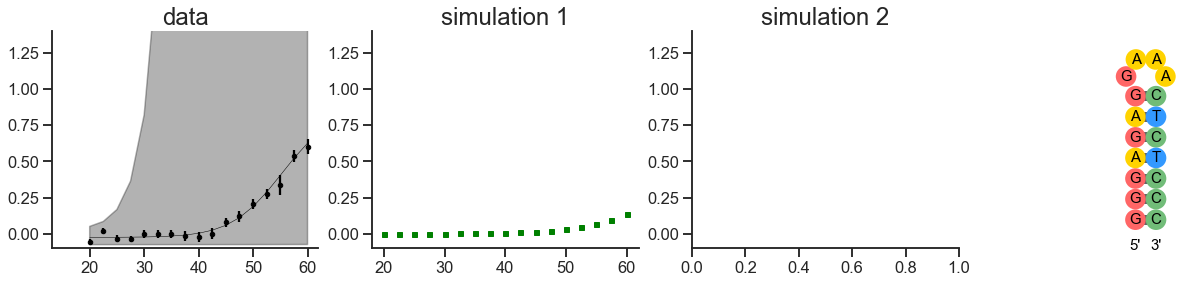

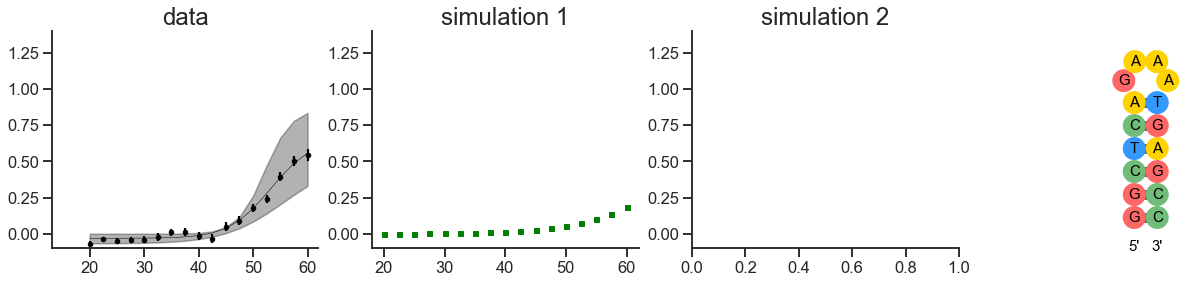

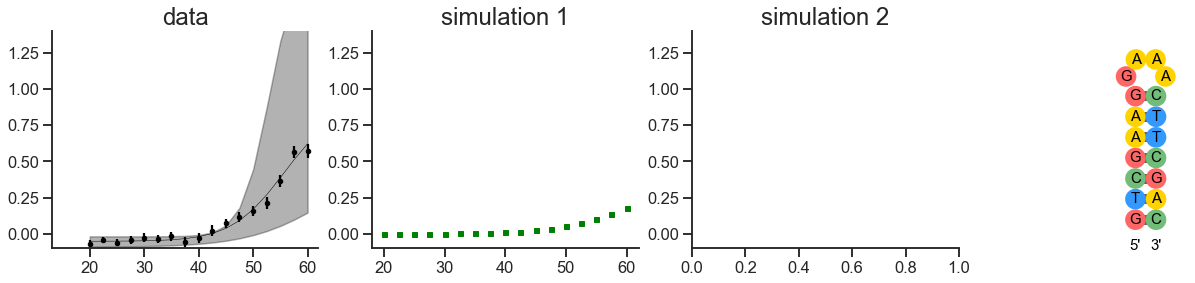

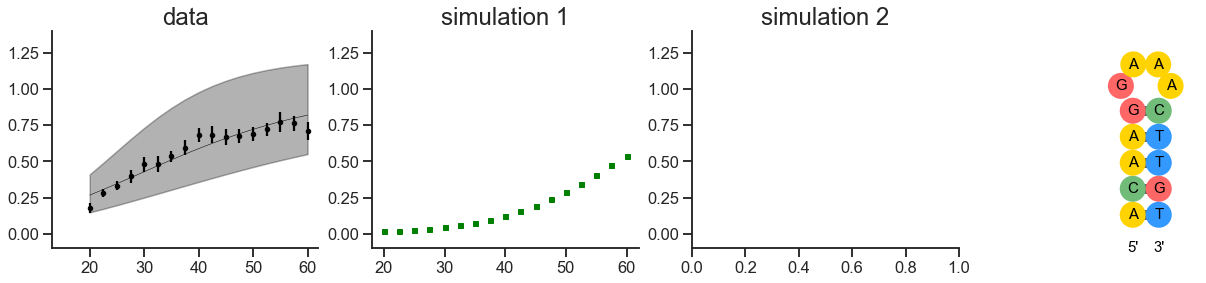

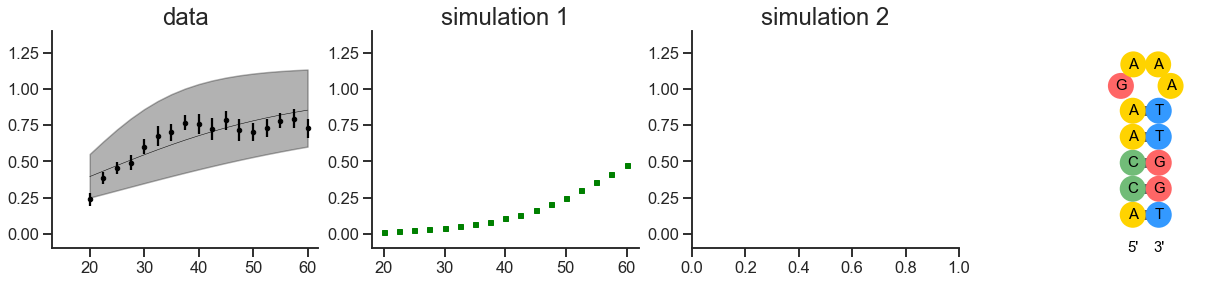

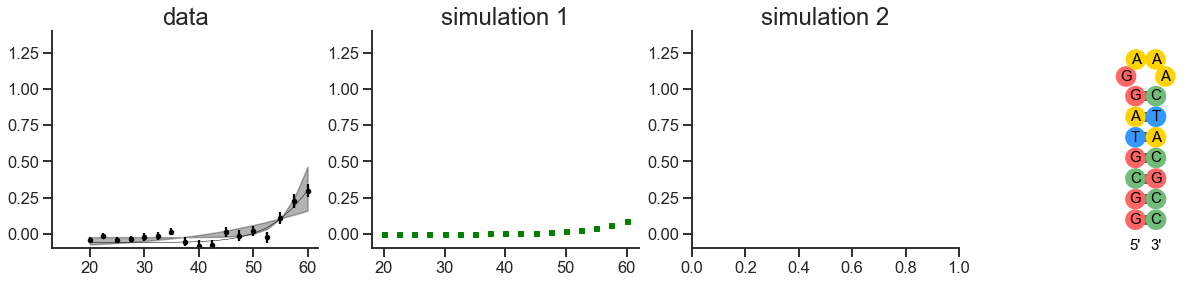

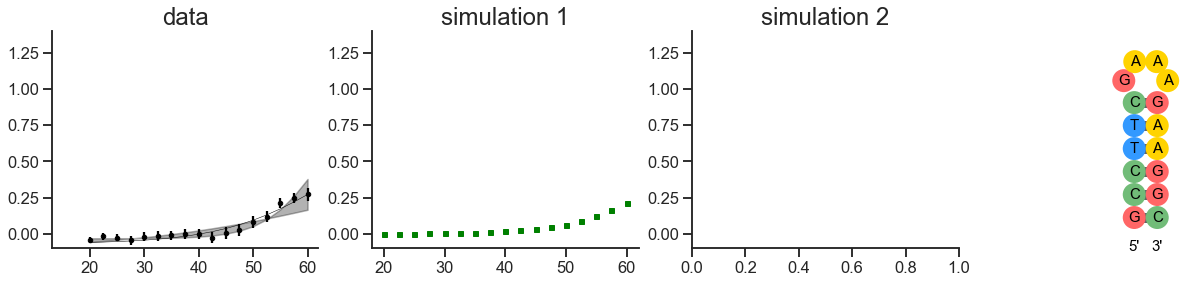

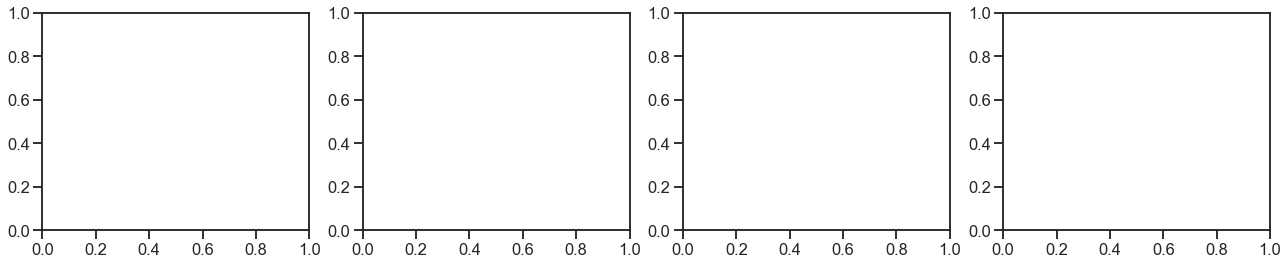

In [46]:
sns.set_context('talk')

ylim = [-0.1,1.4]

for i,seqid in enumerate(df.index):
    seq = df.loc[seqid, 'RefSeq']
    
    fig, ax = plt.subplots(1, 4, figsize=(22,4))
    plotting.plot_actual_and_expected_fit(r2.loc[seqid,:], ax=ax[0])
    # ax[1].plot(T_more, y, 'gs', markersize=5)
    ax[1].plot(T, curves[i, :], 'gs', markersize=5)
    # plot_nupack_curve_by_sampling(seq, num_sample=1000, sodium=0.075, T=T,
    #                       transform_curve=distance_curve, ax=ax[2])
    draw_struct(seq, annotation.loc[seqid, 'TargetStruct'], ax=ax[3])
    sns.despine()
    for a in ax[:3]:
        a.set_ylim(ylim)
    ax[0].set_title('data', size=24)
    ax[1].set_title('simulation 1', size=24)
    ax[2].set_title('simulation 2', size=24)

# Simulate by enumerating over all secondary structures

In [3]:
from nnn import simulation

In [63]:
seq = 'ATACTGAAAAGTAT'
all_structs = simulation.get_all_secondary_structures(seq, dG_gap_kT=1)

print(len(all_structs))
all_structs

4


{'(((((....)))))', '.((((....)))).', '..(((....)))..', '..............'}

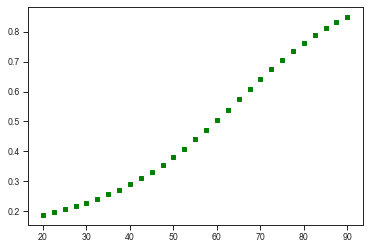

In [69]:
T = np.arange(20, 92.5, 2.5)
curve = simulation.simulate_nupack_curve_all_struct(seq, T=T, sodium=0.075)

plt.plot(T, curve, 'gs')

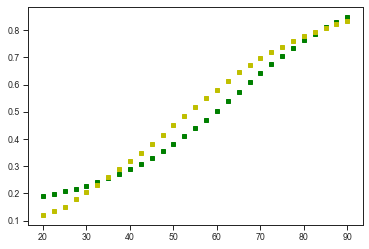

In [73]:
y = simulation.simulate_nupack_curve(seq, sodium=0.075, T=T, 
                          dG_gap_kT=8)

plt.plot(T, curve, 'gs')
plt.plot(T, y, 'ys')


> **AHHHHHHHHH**
>
> OMFG what a headache I roll back to the previous version.

~~~~~ *After nap* ~~~~~~

> **Oh Yeah**
>
> I got it to work